# SSD300 Inference Tutorial

This is a brief tutorial that shows how to use a trained SSD300 for inference on the Pascal VOC datasets. If you'd like more detailed explanations, please refer to [`ssd300_training.ipynb`](https://github.com/pierluigiferrari/ssd_keras/blob/master/ssd300_training.ipynb)

In [1]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss_mod import SSDLoss
from keras_loss_function.keras_ssd_loss_proj import SSDLoss_proj
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize_Modified
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels_Modified
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation_modified
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set the image size.
img_height = 300
img_width = 600

## 1. Load a trained SSD

Either load a trained model or build a model and load trained weights into it. Since the HDF5 files I'm providing contain only the weights for the various SSD versions, not the complete models, you'll have to go with the latter option when using this implementation for the first time. You can then of course save the model and next time load the full model directly, without having to build it.

You can find the download links to all the trained model weights in the README.

### 1.1. Build the model and load trained weights into it

In [3]:
# 1: Build the Keras model

K.clear_session() # Clear precheckpoints/checkpoints/EXP3/double_ssd300_8.h5vious models from memory.

model = ssd_300(image_size=(img_height, img_width, 3),
                n_classes=1,
                mode='inference',
                l2_regularization=0.0005,
                scales=[0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05], # The scales for MS COCO are [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
                two_boxes_for_ar1=True,
                steps=[8, 16, 32, 64, 100, 300],
                offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                clip_boxes=False,
                variances=[0.1, 0.1, 0.2, 0.2],
                normalize_coords=True,
                subtract_mean=[123, 117, 104],
                swap_channels=[2, 1, 0],
                confidence_thresh=0.5,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400)

# 2: Load the trained weights into the model.

# TODO: Set the path of the trained weights.
weights_path = 'checkpoints/EXP3/double_ssd300_8.h5'

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# ssd_loss1 = SSDLoss(neg_pos_ratio=3, alpha=1.0)
# ssd_loss2 = SSDLoss(neg_pos_ratio=3, alpha=1.0)
# ssd_loss3 = SSDLoss_proj(neg_pos_ratio=3, alpha=1.0)
# ssd_loss4 = SSDLoss_proj(neg_pos_ratio=3, alpha=1.0)

# losses = {
#     "predictions_1": ssd_loss1.compute_loss,
#     "predictions_2": ssd_loss2.compute_loss,
#     "predictions_1_proj": ssd_loss3.compute_loss,
#     "predictions_2_proj": ssd_loss4.compute_loss

# }
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

/home/nassar/gits/ssd_keras_double/models/keras_ssd300.py:612: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`
  model = Model(input=[x,geo_1,geo_2],output=[predictions, predictions_proj])


y_p_1:  Tensor("decoded_predictions/loop_over_batch/TensorArrayStack/TensorArrayGatherV3:0", shape=(?, ?, ?), dtype=float32)


In [4]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 300, 600, 3)   0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 300, 600, 3)   0                                            
____________________________________________________________________________________________________
identity_layer__1 (Lambda)       (None, 300, 600, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
identity_layer__2 (Lambda)       (None, 300, 600, 3)   0           input_2[0][0]                    
___________________________________________________________________________________________

## 2. Load some images

Load some images for which you'd like the model to make predictions.

In [5]:
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

# We'll only load one image in this example.
img_path = '../datasets/Images/7tdpKEm0YIlJVJ8AK7zkdw_z2.jpg'

orig_images.append(imread(img_path))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img) 
input_images.append(img)
input_images = np.array(input_images)

In [6]:
orig_images1 = [] # Store the images here.
input_images1 = [] # Store resized versions of the images here.

# We'll only load one image in this example.
img_path1 = '../datasets/Images/ZrJFziHS3ADOec3trJb8hA_z2.jpg'

orig_images1.append(imread(img_path1))
img1 = image.load_img(img_path1, target_size=(img_height, img_width))
img1 = image.img_to_array(img1) 
input_images1.append(img1)
input_images1 = np.array(input_images1)

## 3. Make predictions

In [7]:
geox = np.tile(np.array([34.156992,-118.165118,0.9073966781118519],dtype=np.float64), (17292,1))
geoz = np.tile(np.array([34.156939,-118.165203,0.9061749476354559],dtype=np.float64), (17292,1))

geox = np.array([34.1513108639,-118.135291797,20],dtype=np.float64)
geoz = np.array([34.1513108639,-118.135291797,21],dtype=np.float64)

In [8]:
geox = np.expand_dims(geox, axis=0)
geoz = np.expand_dims(geoz, axis=0)

In [9]:
y_pred = model.predict([input_images,input_images1,geox,geoz])

`y_pred` contains a fixed number of predictions per batch item (200 if you use the original model configuration), many of which are low-confidence predictions or dummy entries. We therefore need to apply a confidence threshold to filter out the bad predictions. Set this confidence threshold value how you see fit.

In [10]:
y_pred

array([[[  1.        ,   0.99848026, 187.63153   , ..., 110.78679   ,
         289.2132    , 153.2132    ],
        [  1.        ,   0.9959586 ,   3.187041  , ...,  90.        ,
         230.00002   , 150.        ],
        [  1.        ,   0.96540016, 438.2372    , ...,  56.5       ,
         519.5       , 167.5       ],
        ...,
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]]], dtype=float32)

In [11]:
y_pred_1 = y_pred[:,:,:6]
y_pred_2 = y_pred[:,:,6:12]
y_pred_1_p = y_pred[:,:,12:18]
y_pred_2_p = y_pred[:,:,18:24]

In [12]:
confidence_threshold = 0.5

y_pred_thresh_1 = [y_pred_1[k][y_pred_1[k,:,1] > confidence_threshold] for k in range(y_pred_1.shape[0])]
y_pred_thresh_2 = [y_pred_2[k][y_pred_2[k,:,1] > confidence_threshold] for k in range(y_pred_2.shape[0])]
y_pred_thresh_1_p = [y_pred_1_p[k][y_pred_1_p[k,:,1] > confidence_threshold] for k in range(y_pred_1_p.shape[0])]
y_pred_thresh_2_p = [y_pred_2_p[k][y_pred_2_p[k,:,1] > confidence_threshold] for k in range(y_pred_2_p.shape[0])]

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes 1:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh_1[0])
print("Predicted boxes 2n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh_2[0])
print("Predicted boxes 1 proj")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh_1_p[0])
print("Predicted boxes 2 proj")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh_2_p[0])


Predicted boxes 1:

   class   conf xmin   ymin   xmax   ymax
[[  1.     1.   187.63  74.56 292.5  169.9 ]
 [  1.     1.     3.19  43.78 125.67 163.47]
 [  1.     0.97 438.24  56.25 556.75 164.04]
 [  1.     0.94 306.38  92.32 355.95 156.06]
 [  1.     0.86 365.4  102.09 412.17 162.28]
 [  1.     0.68 122.73  90.34 181.16 158.71]]
Predicted boxes 2n
   class   conf xmin   ymin   xmax   ymax
[[  1.     0.99 244.54 106.69 291.6  159.56]
 [  1.     0.8  168.18  91.37 225.77 161.46]
 [  1.     0.78 413.4   48.62 505.34 166.63]
 [  1.     0.69 221.2  108.   248.72 154.76]
 [  1.     0.65   6.75  17.23 219.09 184.25]
 [  1.     0.64 306.58  99.94 337.62 156.23]
 [  1.     0.53 332.13 115.73 355.35 157.67]
 [  1.     0.52 348.1  113.41 376.39 160.23]]
Predicted boxes 1 proj
   class   conf xmin   ymin   xmax   ymax
[[  1.     1.   207.2   79.2  288.8  160.8 ]
 [  1.     1.    12.95  44.95 147.05 179.05]
 [  1.     0.97 440.5   56.5  551.5  167.5 ]
 [  1.     0.94 306.79  77.57 349.21 162.43]


## 4. Visualize the predictions

We just resized the input image above and made predictions on the distorted image. We'd like to visualize the predictions on the image in its original size though, so below we'll transform the coordinates of the predicted boxes accordingly.

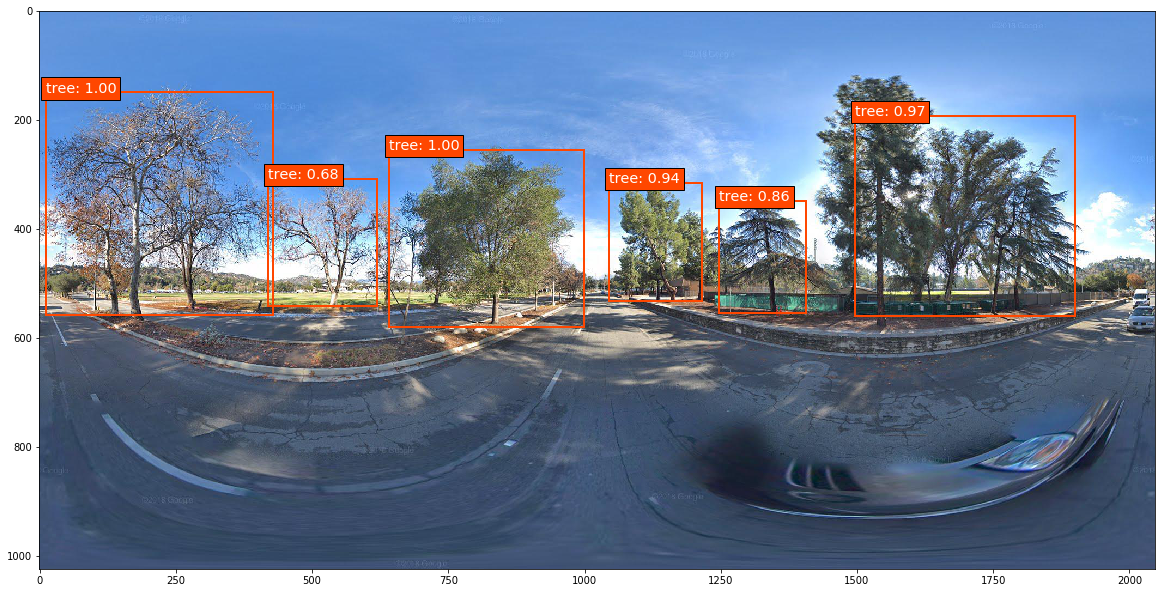

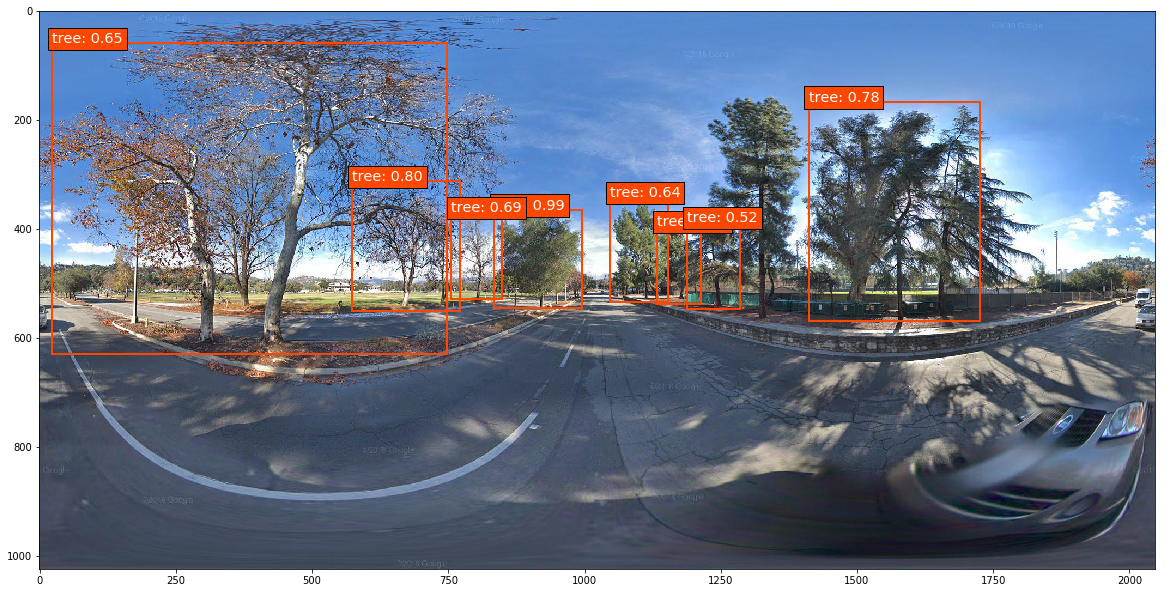

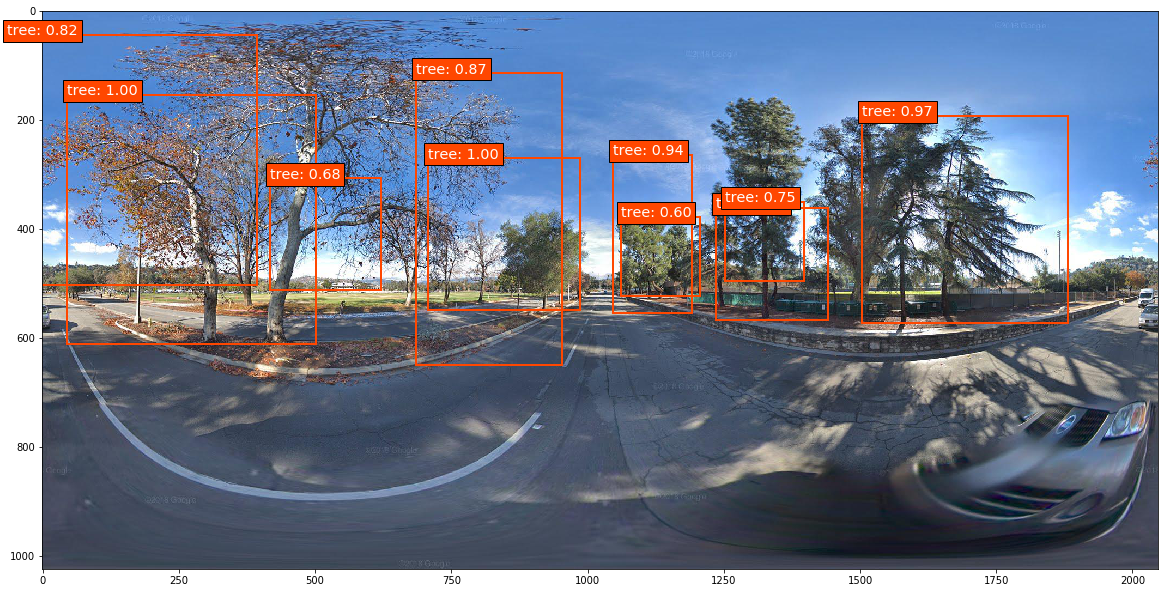

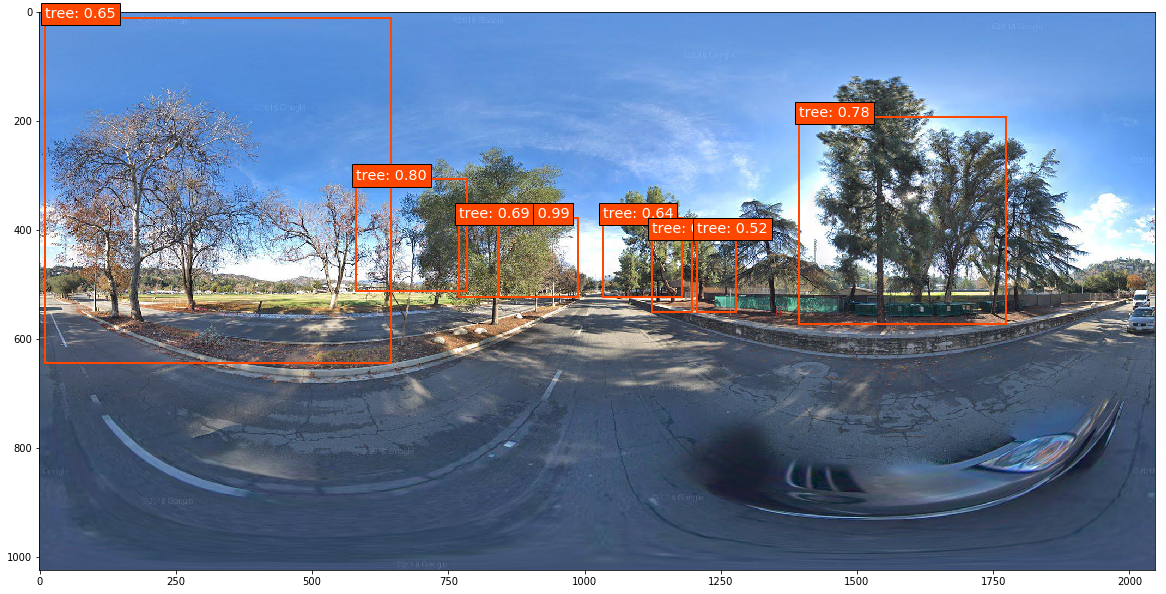

In [17]:
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background',
           'tree']

plt.figure(figsize=(20,12))
plt.imshow(orig_images[0])

current_axis = plt.gca()

for box in y_pred_thresh_1[0]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[2] * orig_images[0].shape[1] / img_width
    ymin = box[3] * orig_images[0].shape[0] / img_height
    xmax = box[4] * orig_images[0].shape[1] / img_width
    ymax = box[5] * orig_images[0].shape[0] / img_height
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})
    
plt.figure(figsize=(20,12))
plt.imshow(orig_images1[0])

current_axis = plt.gca()

for box in y_pred_thresh_2[0]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[2] * orig_images1[0].shape[1] / img_width
    ymin = box[3] * orig_images1[0].shape[0] / img_height
    xmax = box[4] * orig_images1[0].shape[1] / img_width
    ymax = box[5] * orig_images1[0].shape[0] / img_height
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})
    
plt.figure(figsize=(20,12))
plt.imshow(orig_images1[0])

current_axis = plt.gca()

for box in y_pred_thresh_1_p[0]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[2] * orig_images1[0].shape[1] / img_width
    ymin = box[3] * orig_images1[0].shape[0] / img_height
    xmax = box[4] * orig_images1[0].shape[1] / img_width
    ymax = box[5] * orig_images1[0].shape[0] / img_height
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})
    
plt.figure(figsize=(20,12))
plt.imshow(orig_images[0])

current_axis = plt.gca()

for box in y_pred_thresh_2_p[0]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[2] * orig_images[0].shape[1] / img_width
    ymin = box[3] * orig_images[0].shape[0] / img_height
    xmax = box[4] * orig_images[0].shape[1] / img_width
    ymax = box[5] * orig_images[0].shape[0] / img_height
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})